# **Лабораторная работа №2.**

## Задание

Реализовать операцию свертки поэлементную и с использованием алгоритма ```Im2Col```

##### Выполнил: Викулов Максим

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

### 1. Реализация поэлементной свертки

In [2]:
def numpy_conv2d(input_, kernel, padding=0, stride=1):
    if input_.ndim == 2:
        input_ = np.expand_dims(input_, axis=0)
    if kernel.ndim == 2:
        kernel = np.expand_dims(np.expand_dims(kernel, axis=0), axis=0)
    
    C_in, H_in, W_in = input_.shape
    C_out, _, KH, KW = kernel.shape
    
    if padding > 0:
        padded = np.zeros((C_in, H_in + 2 * padding, W_in + 2 * padding))
        padded[:, padding:-padding, padding:-padding] = input_
    else:
        padded = input_
    
    H_out = (H_in + 2 * padding - KH) // stride + 1
    W_out = (W_in + 2 * padding - KW) // stride + 1
    output = np.zeros((C_out, H_out, W_out))
    
    for oc in range(C_out):
        for ic in range(C_in):
            for h in range(H_out):
                for w in range(W_out):
                    h_start = h * stride
                    w_start = w * stride
                    output[oc, h, w] += np.sum(
                        padded[ic, h_start:h_start + KH, w_start:w_start + KW] * kernel[oc, ic]
                    )
    
    return output.squeeze()

### 2. Реализация свертки с помощью алгоритма Im2Col

In [3]:
def Im2Col(input_, kernel, padding=0, stride=1):
    if input_.ndim == 2:
        input_ = np.expand_dims(input_, axis=0)
    
    C_in, H_in, W_in = input_.shape
    KH, KW = kernel
    
    if padding > 0:
        padded_input = np.zeros((C_in, H_in + 2 * padding, W_in + 2 * padding))
        padded_input[:, padding:-padding, padding:-padding] = input_
    else:
        padded_input = input_
    
    H_out = (H_in + 2 * padding - KH) // stride + 1
    W_out = (W_in + 2 * padding - KW) // stride + 1
    col_matrix = np.zeros((C_in * KH * KW, H_out * W_out))
    
    for h in range(H_out):
        for w in range(W_out):
            h_start = h * stride
            w_start = w * stride
            patch = padded_input[:, h_start:h_start + KH, w_start:w_start + KW]
            col_matrix[:, h * W_out + w] = patch.ravel()
    
    return col_matrix


def conv2d_im2col(input_, kernel, padding=0, stride=1):
    if input_.ndim == 2:
        input_ = np.expand_dims(input_, axis=0)
    if kernel.ndim == 2:
        kernel = np.expand_dims(np.expand_dims(kernel, axis=0), axis=0)
    
    C_in, H_in, W_in = input_.shape
    C_out, in_c_k, KH, KW = kernel.shape
    
    if C_in != in_c_k:
        raise ValueError(f"Количество каналов во входе ({C_in}) не совпадает с ядром ({in_c_k})")
    
    col_matrix = Im2Col(input_, (KH, KW), padding, stride)
    kernel_matrix = kernel.reshape(C_out, -1)
    out = kernel_matrix @ col_matrix
    H_out = (H_in + 2 * padding - KH) // stride + 1
    W_out = (W_in + 2 * padding - KW) // stride + 1
    
    return out.reshape(C_out, H_out, W_out).squeeze()

Размер: 16x16 | Numpy: 0.0024s | Im2Col: 0.0004s | Проверка: OK
Размер: 28x28 | Numpy: 0.0314s | Im2Col: 0.0009s | Проверка: OK
Размер: 32x32 | Numpy: 0.0125s | Im2Col: 0.0013s | Проверка: OK
Размер: 50x50 | Numpy: 0.3623s | Im2Col: 0.0036s | Проверка: OK
Размер: 64x64 | Numpy: 0.2669s | Im2Col: 0.0062s | Проверка: OK
Размер: 64x64 | Numpy: 0.4461s | Im2Col: 0.0080s | Проверка: OK
Размер: 100x100 | Numpy: 0.3700s | Im2Col: 0.0133s | Проверка: OK
Размер: 128x128 | Numpy: 0.9105s | Im2Col: 0.0242s | Проверка: OK
Размер: 256x256 | Numpy: 13.9756s | Im2Col: 0.1153s | Проверка: OK


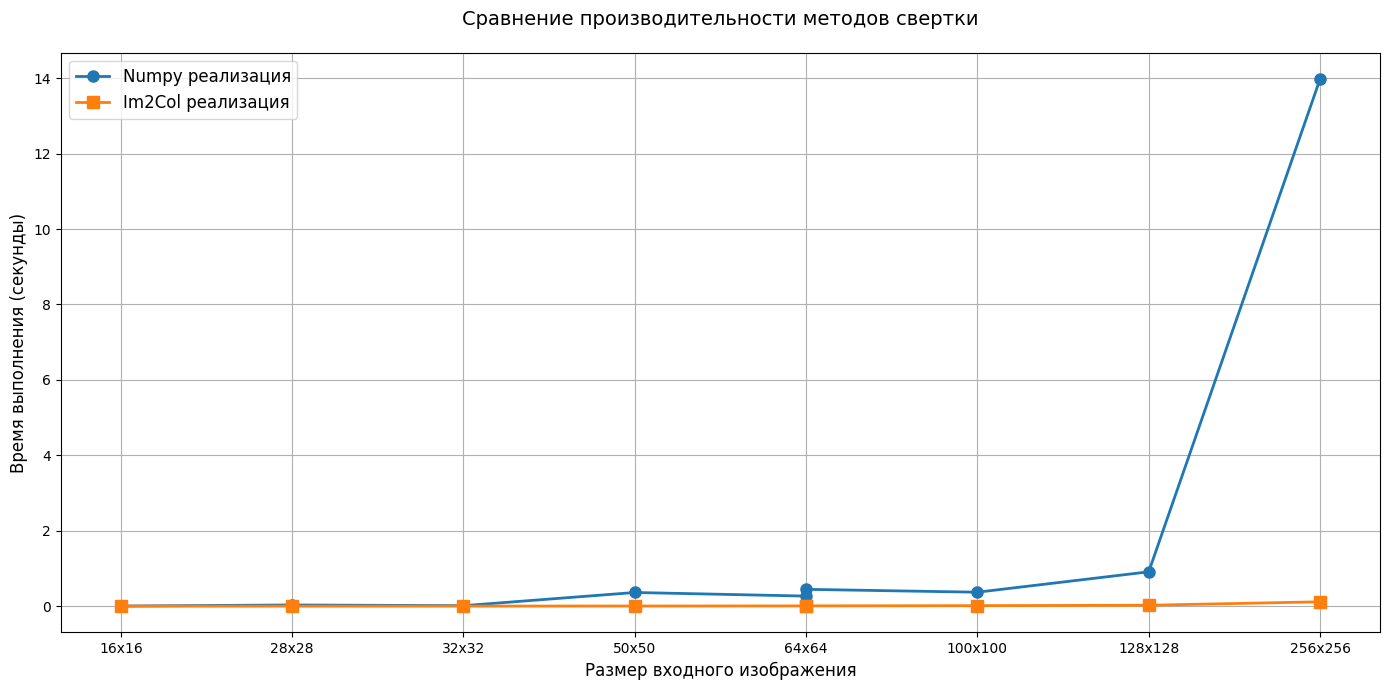

In [4]:
def test():
    np.random.seed(42)
    torch.manual_seed(42)
    
    sizes = [
        (1, 16, 16),
        (1, 28, 28),
        (1, 32, 32),
        (4, 50, 50),
        (3, 64, 64),
        (3, 64, 64),
        (2, 100, 100),
        (3, 128, 128),
        (3, 256, 256),
    ]
    
    kernels = [
        np.random.randn(2, 1, 3, 3),
        np.random.randn(10, 1, 5, 5),
        np.random.randn(3, 1, 5, 5),
        np.random.randn(8, 4, 3, 3),
        np.random.randn(4, 3, 3, 3),
        np.random.randn(8, 3, 7, 7),
        np.random.randn(4, 2, 1, 1),
        np.random.randn(4, 3, 3, 3),
        np.random.randn(16, 3, 5, 5),
    ]
    
    numpy_times = []
    im2col_times = []
    size_labels = []
    errors = []
    
    for size, kernel in zip(sizes, kernels):
        input_np = np.random.randn(*size)
        input_torch = torch.tensor(input_np, dtype=torch.float32)
        
        start = time.perf_counter()
        out_numpy = numpy_conv2d(input_np, kernel, padding=1)
        numpy_time = time.perf_counter() - start
        
        start = time.perf_counter()
        out_im2col = conv2d_im2col(input_np, kernel, padding=1)
        im2col_time = time.perf_counter() - start
        
        kernel_torch = torch.tensor(kernel, dtype=torch.float32)
        out_torch = F.conv2d(input_torch.unsqueeze(0), kernel_torch, padding=1)
        
        try:
            np.testing.assert_allclose(out_numpy, out_im2col, rtol=1e-03, atol=1e-03)
            np.testing.assert_allclose(out_numpy, out_torch.squeeze().numpy(), rtol=1e-03, atol=1e-03)
            error = "OK"
        except AssertionError as e:
            error = f"Ошибка: {str(e).split('\n')[0]}"
        
        numpy_times.append(numpy_time)
        im2col_times.append(im2col_time)
        size_labels.append(f"{size[1]}x{size[2]}")
        errors.append(error)
        
        print(f"Размер: {size[1]}x{size[2]} | Numpy: {numpy_time:.4f}s | Im2Col: {im2col_time:.4f}s | Проверка: {error}")
    
    plt.figure(figsize=(14, 7))
    plt.plot(size_labels, numpy_times, 'o-', label='Numpy реализация', linewidth=2, markersize=8)
    plt.plot(size_labels, im2col_times, 's-', label='Im2Col реализация', linewidth=2, markersize=8)
    
    for i, error in enumerate(errors):
        if error != "OK":
            plt.annotate(
                        error, 
                        xy=(i, max(numpy_times[i], im2col_times[i])),
                        xytext=(0, 20), 
                        textcoords='offset points',
                        ha='center', 
                        color='red',
                        arrowprops=dict(arrowstyle="->", color='red')
                    )
    
    plt.title('Сравнение производительности методов свертки', fontsize=14, pad=20)
    plt.xlabel('Размер входного изображения', fontsize=12)
    plt.ylabel('Время выполнения (секунды)', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()


if __name__ == "__main__":
    test()